# ARIMA-LR Model

#### Hengxu Zhu 
#### Zixuan(Kate) Shi 

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.api as sm 
import warnings
import statsmodels.api as sm
import itertools 
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller

In [119]:
# Setting the file path for the data:
path =r"Neuberger_Data.xlsx"
df =  pd.read_excel(path,index_col = 0)
X = df

# Setting the independent and dependent variable:
X = X.drop(['SPX Index', 'USGG10YR Index', 'EMBI GD Total', 'EMBI GD IG', 'CEMBI Total','ISM Non-Manufacturing Report on Business Inventory Sentiment NSA'
            ,'Bank of France Business Sentiment Indicator', 'European Commission Economic  Sentiment Indicator Eurozone'],axis = 1)
y = df['EMBI GD Total']

# Adding a constant to the independent variables:
X = sm.add_constant(X)
# fitting the OLS model:
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          EMBI GD Total   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     60.98
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           1.30e-39
Time:                        14:52:57   Log-Likelihood:                -1260.6
No. Observations:                 225   AIC:                             2533.
Df Residuals:                     219   BIC:                             2554.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
const                                                           750.8537     64.436     11.653      0.000     623.859     877.848
SP Oil Index                                                     -0.6930      0.078     -8.852      0.000      -0.847      -0.539
PMI Index                                                        -9.5441      0.966     -9.883      0.000     -11.447      -7.641
AAII Investor Sentiment                                          -2.0378      0.581     -3.508      0.001      -3.183      -0.893
Conference Board Consumer Confidence Inflation Rate Exp 12m      52.4388      8.308      6.312      0.000      36.066      68.812
US Misery Index                                                   7.4668      2.904      2.572      0.011       1.744      13.189
==============================================================================
Omnibus:                        1.713   Durbin-Watson:                   0.407
Prob(Omnibus):                  0.425   Jarque-Bera (JB):                1.398
Skew:                          -0.102   Prob(JB):                        0.497
Kurtosis:                       3.328   Cond. No.                     3.89e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

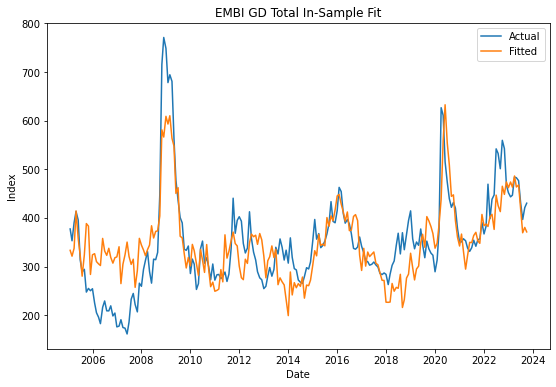

In [120]:
# Predicting the dependent variable using the fitted model:
y_pred = model.predict(X)

# Visualization: plotting actual and fitted values
plt.figure(figsize=(9,6))
plt.plot(y, label = 'Actual')
plt.plot(pd.DataFrame(data = y_pred,index = y.index), label='Fitted')
plt.xlabel('Date') 
plt.ylabel('Index')
plt.title('EMBI GD Total In-Sample Fit')
plt.legend()
plt.show()

In [124]:
# Performing a time series split for a regression analysis using the Ordinary Least Squares (OLS)

# Initializing the Time Series Split:
tscv = TimeSeriesSplit(n_splits=2)  
# Splitting the Data into Training and Testing Sets:
X_train = X[X.index <= '2022-09-30']
X_test = X[X.index > '2022-09-30']
y_train = y[y.index <= '2022-09-30']
y_test = y[y.index > '2022-09-30']
# Fitting the OLS Model on the Training Data:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)
model_ols = sm.OLS(y_train, X_train_sm).fit()
# Predicting on Training and Testing Data:
y_fit = model_ols.predict(X_train_sm)
y_pred = model_ols.predict(X_test_sm) 

In [122]:
# Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity. 
def testStationarity(df):
    results = []
    for column in df.columns[1:]:
        adf_result = adfuller(df[column].dropna()) # Performing the ADF Test
        test_statistic = adf_result[0] # Extracting Test Statistic 
        p_value = adf_result[1] # Extracting P-Value
        results.append([column, test_statistic, p_value])
    results_df = pd.DataFrame(results, columns=['Column', 'Test statistic', 'P-Value'])
    results_df.set_index('Column', inplace=True)
    return results_df

# Test the stationarity for independent variables 
testStationarity(X)

,Test statistic,P-Value
Column,,
SP Oil Index,-2.944177,4.044674e-02
PMI Index,-3.294400,1.513068e-02
AAII Investor Sentiment,-6.640457,5.426493e-09
Conference Board Consumer Confidence Inflation Rate Exp 12m,-3.279433,1.582325e-02
US Misery Index,-2.819490,5.554326e-02


In [123]:
# Selecting and creating new dataframe for each selected column
oil = X[['SP Oil Index']] 
pmi = X[['PMI Index']]
aaii = X[['AAII Investor Sentiment']]
cpi = X[['Conference Board Consumer Confidence Inflation Rate Exp 12m  ']] 
mi = X[['US Misery Index']]

In [8]:
# Function designed to determine the best parameters (p,d,q) for an ARIMA model for a given time series
# ARIMA, which stands for AutoRegressive Integrated Moving Average
# p (Autoregression - AR): number of lag observations included in the model, also known as the lag order.
# d (Differencing - I): number of differencing needed, also known as the degree of differencing.
# q (Moving Average - MA): number of lagged forecast errors in the prediction equation.
def arima_param_selection(df): 
    warnings.filterwarnings("ignore") 
    p = d = q = range(0, 3) # Setup Parameter Range
    pdq = list(itertools.product(p, d, q))
    lowest_aic = float('inf')
    best_pdq = None
    for param in pdq:
        try:
            model = sm.tsa.ARIMA(df, order=param)
            results = model.fit()
            
            if results.aic < lowest_aic: # using Akaike Information Criterion (AIC) 
                lowest_aic = results.aic # Updating the Lowest AIC Value
                best_pdq = param
        except:
            continue
    return best_pdq # Returning the Best Parameters

In [9]:
# Determine the best ARIMA parameters for each independent variables
dfs = [oil, pmi, aaii, cpi, mi]
arima_params = []
for df in dfs: 
    df_train = df[df.index <='2022-09-30']
    param = arima_param_selection(df_train)
    arima_params.append(param)
    print(f"{df.columns[0]}: {param}") 

SP Oil Index: (1, 2, 1)
PMI Index: (2, 0, 1)
AAII Investor Sentiment: (2, 1, 1)
Conference Board Consumer Confidence Inflation Rate Exp 12m  : (2, 1, 1)
US Misery Index: (0, 1, 0)


In [10]:
# Ditted the ARIMA model for each independent variables by using the corresponding best ARIMA parameters identified previously 
models = [] 
for i, df in enumerate(dfs):
    df_train = df[df.index <= '2022-09-30']
    model = sm.tsa.ARIMA(df_train, order=arima_params[i]).fit()
    models.append(model)

In [11]:
# Using each ARIMA Models to forecast for the next 12 months, starting from '2022-10-31
forecast_df = pd.DataFrame()
forecast_dates = pd.date_range(start='2022-10-31', periods=12, freq='M')
for i, model in enumerate(models):
    forecast = model.get_forecast(steps=12)
    predicted_mean = forecast.predicted_mean
    forecast_df[dfs[i].columns[0]] = predicted_mean
forecast_df.index = df.index[-12:]
forecast_df

,SP Oil Index,PMI Index,AAII Investor Sentiment,Conference Board Consumer Confidence Inflation Rate Exp 12m,US Misery Index
Date,,,,,
2022-10-31,284.472866,50.579087,27.877870,6.866725,12.0
2022-11-30,282.085874,50.250142,29.359740,6.945282,12.0
2022-12-30,281.847514,50.009219,31.088298,6.995595,12.0
2023-01-31,282.174462,49.851284,31.906457,7.022820,12.0
2023-02-28,282.650145,49.770413,32.453384,7.036462,12.0
2023-03-31,283.164960,49.759981,32.766552,7.043017,12.0
2023-04-28,283.690070,49.812854,32.958067,7.046088,12.0
2023-05-31,284.217889,49.921559,33.071875,7.047504,12.0
2023-06-30,284.746421,50.078449,33.140347,7.048151,12.0


In [12]:
# Using the ARIMA model forecasts as input for an OLS model to make further predictions
X_forecast = forecast_df
X_forecast_sm = sm.add_constant(X_forecast, has_constant='add')
y_forecast = model_ols.predict(X_forecast_sm)

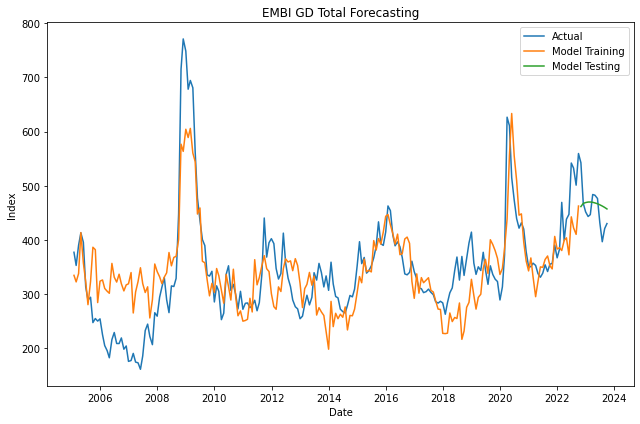

In [13]:
# Plot a comparison between actual values, model training predictions, and model testing (forecasting) predictions 
plt.figure(figsize=(9,6))
plt.title('EMBI GD Total Forecasting')

plt.plot(y, label='Actual') 
plt.plot(pd.DataFrame(data = y_fit,index = y_train.index), label='Model Training')
plt.plot(pd.DataFrame(data = y_forecast,index = y_test.index), label='Model Testing')

plt.xlabel('Date') 
plt.ylabel('Index')
plt.legend()
plt.tight_layout()
plt.show()

In [72]:
y_new = y['2013-09-30':]

In [76]:
# Combine ARIMA and linear regression models for forecasting
def arimalr_model(df, period): 
    forecast_p = pd.DataFrame()
    X_trains = [] 
    # Looping Over Time Periods:
    for j in range(0, len(df.index[105:]), period): 
        # Creating Training Sets for Each Period:
        X_train = X[X.index <= df.index[105+j]] 
        y_train = y[y.index <= df.index[105+j]] 
        X_trains.append(sm.add_constant(X_train)) 
        # Finding ARIMA Parameters for Each: 
        arima_params = [] 
        for df in dfs: 
            df_train = df[df.index <= df.index[105+j]]
            param = arima_param_selection(df_train)
            arima_params.append(param)
        # Fitting ARIMA Models and Forecasting:
        models = [] 
        for i, df in enumerate(dfs):
            df_train = df[df.index <= df.index[105+j]]
            model = sm.tsa.ARIMA(df_train, order=arima_params[i]).fit()
            models.append(model) 
        # Creating Forecast DataFrame:
        forecast_df = pd.DataFrame()
        for i, model in enumerate(models):
            forecast = model.get_forecast(steps=period)
            predicted_mean = forecast.predicted_mean
            forecast_df[dfs[i].columns[0]] = predicted_mean 
        # Fitting OLS Model and Generating Final Forecast:
        model_ols = sm.OLS(y_train, X_train).fit()
        y_forecast = model_ols.predict(sm.add_constant(forecast_df, has_constant='add')).to_frame()
        forecast_p = pd.concat([forecast_p, y_forecast]) 
    return forecast_p

In [77]:
# Forcasting 12 months
forecast_y = arimalr_model(df, 12)

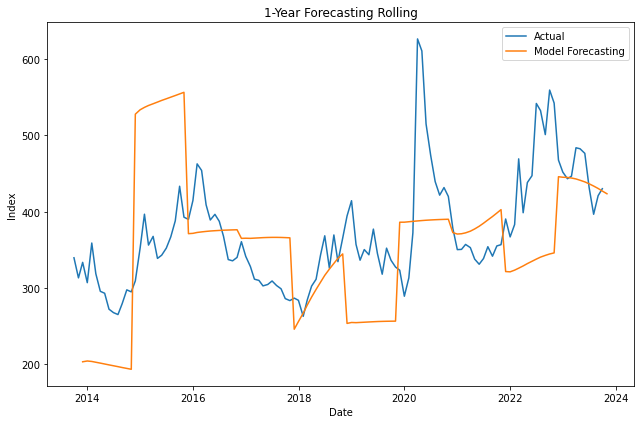

In [78]:
# 1-Year Forecasting Rolling
plt.figure(figsize=(9,6))
plt.title('EMBI GD Total Forecasting')
plt.plot(y_new, label='Actual') 
plt.plot(pd.DataFrame(data = forecast_y), label='Model Forecasting')$
plt.xlabel('Date') 
plt.ylabel('Index') 
plt.title('1-Year Forecasting Rolling')
plt.legend()
plt.tight_layout()
plt.show()

In [81]:
# Forecasting 3 months
forecast_q = arimalr_model(df, 3) 

In [92]:
# The model has 3 weird forecasts that are so large and we eliminate them
forecast_q_new = forecast_q[~(forecast_q[0].isin(sorted(forecast_q[0])[-3:]))]

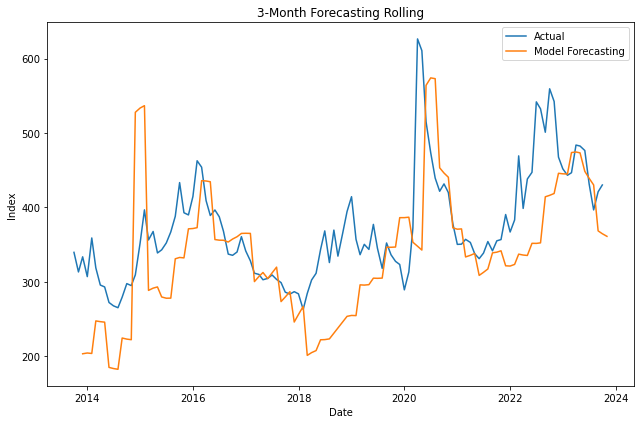

In [93]:
# 3-month Forecasting Rolling
plt.figure(figsize=(9,6))
plt.title('EMBI GD Total Forecasting')
plt.plot(y_new, label='Actual') 
plt.plot(pd.DataFrame(data = forecast_q_new), label='Model Forecasting')
plt.xlabel('Date') 
plt.ylabel('Index') 
plt.title('3-Month Forecasting Rolling')
plt.legend()
plt.tight_layout()
plt.show()

In [83]:
# Forecasting 1 month
forecast_m = arimalr_model(df, 1)

In [94]:
# The model has 1 weird forecast that are so large and we eliminate them
forecast_m_new = forecast_m[~(forecast_m[0].isin(sorted(forecast_m[0])[-1:]))]

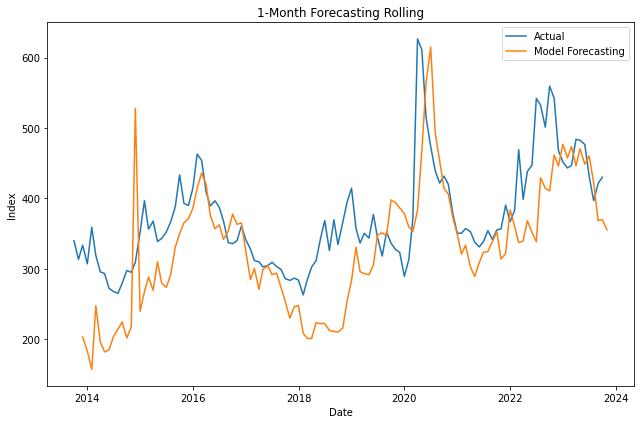

In [95]:
# 1-Month Forecasting Rolling
plt.figure(figsize=(9,6))
plt.title('EMBI GD Total Forecasting')
plt.plot(y_new, label='Actual') 
plt.plot(pd.DataFrame(data = forecast_m_new), label='Model Forecasting')
plt.xlabel('Date') 
plt.ylabel('Index')
plt.title('1-Month Forecasting Rolling')
plt.legend()
plt.tight_layout()
plt.show()

In [126]:
# Calculating hit rate for each forecasting model
hit_y = pd.concat([y_new, forecast_y], axis=1).rename(columns={'EMBI GD Total': 'Actual', 0: 'Forecast'}).dropna()
hit_q = pd.concat([y_new, forecast_q], axis=1).rename(columns={'EMBI GD Total': 'Actual', 0: 'Forecast'}).dropna()
hit_m = pd.concat([y_new, forecast_m], axis=1).rename(columns={'EMBI GD Total': 'Actual', 0: 'Forecast'}).dropna()

In [146]:
# Defining hit rate calculation
def hit_rate_cal(hit): 
    hit['Actual_change'] = hit['Actual'] - hit['Actual'].shift() 
    hit['Forecast_change'] = hit['Forecast'] - hit['Forecast'].shift()
    hit['sig_act'] = hit['Actual_change'].apply(lambda x: 1 if x>0 else -1) 
    hit['sig_fore'] = hit['Forecast_change'].apply(lambda x: 1 if x>0 else -1) 
    hit['hit'] = ((hit['sig_fore'] * hit['sig_act']) > 0).astype(int) 
    return f"{round(len(hit[hit['hit']==1])/len(hit)*100, 2)}%"

In [152]:
hit_rate = pd.DataFrame() 
for i in range(10): 
    hit_y_temp = hit_y[12*i:] 
    hit_q_temp = hit_q[12*i:] 
    hit_m_temp = hit_m[12*i:] 
    hit_rate[hit_y.index[12*i].year] = {'Annually': hit_rate_cal(hit_y_temp), 'Quarterly': hit_rate_cal(hit_q_temp), 'Monthly': hit_rate_cal(hit_m_temp)}

In [153]:
hit_rate = hit_rate.T 
hit_rate

,Annually,Quarterly,Monthly
2013,54.62%,57.98%,50.42%
2014,53.27%,57.01%,51.4%
2015,50.53%,55.79%,53.68%
2016,53.01%,53.01%,54.22%
2017,53.52%,56.34%,52.11%
2018,52.54%,57.63%,49.15%
2019,55.32%,59.57%,48.94%
2020,60.0%,62.86%,48.57%
2021,60.87%,65.22%,39.13%
2022,63.64%,81.82%,54.55%
